# EGH400 Engineering Thesis
---
*Exploration & Analysis of Machine Learning Methods in Traffic Forecasting*<br/>
**By**: Bailey Nugent<br/>
**Supervisor**: Dr Simon Denman<br/>
**Industry Partner**: Transmax<br/>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.metrics import mean_squared_error

### Helper Functions


In [3]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

### Loading Data

In [81]:
def create_multivariate_dataset(path):
    df = pd.read_csv(path,usecols=['starttime','volume'])
    df = df.sort_values(by=['starttime'])
    #convert starttime to UTC+10
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['starttime'] = df['starttime'] + pd.Timedelta(hours=10)
    df.head()
    #split starttime into year, month, day, hour, minute columns
    df['day'] = df['starttime'].dt.day
    df['hour'] = df['starttime'].dt.hour
    df['minute'] = df['starttime'].dt.minute
    #create column for day of week
    df['dayofweek'] = df['starttime'].dt.dayofweek
    #is it a weekday or weekend?
    df['isweekday'] = df['dayofweek'].apply(lambda x: 1 if x < 5 else 0)
    #remove starttime column
    df.drop(['starttime'],axis=1,inplace=True) 
    train = df.iloc[:int(len(df)*0.8)].to_numpy().astype(int)
    test = df.iloc[int(len(df)*0.8):].to_numpy().astype(int) 
    return train,test

def create_univariate_dataset(path):
    df = pd.read_csv(path,usecols=['starttime','volume'])
    df = df.sort_values(by=['starttime'])
    #drop nan rows
    df.dropna(inplace=True)
    df.drop(['starttime'],axis=1,inplace=True)
    #split into train and test
    train = df.iloc[:int(len(df)*0.8)]
    test = df.iloc[int(len(df)*0.8):]
    return train,test

### Data Visualisation 

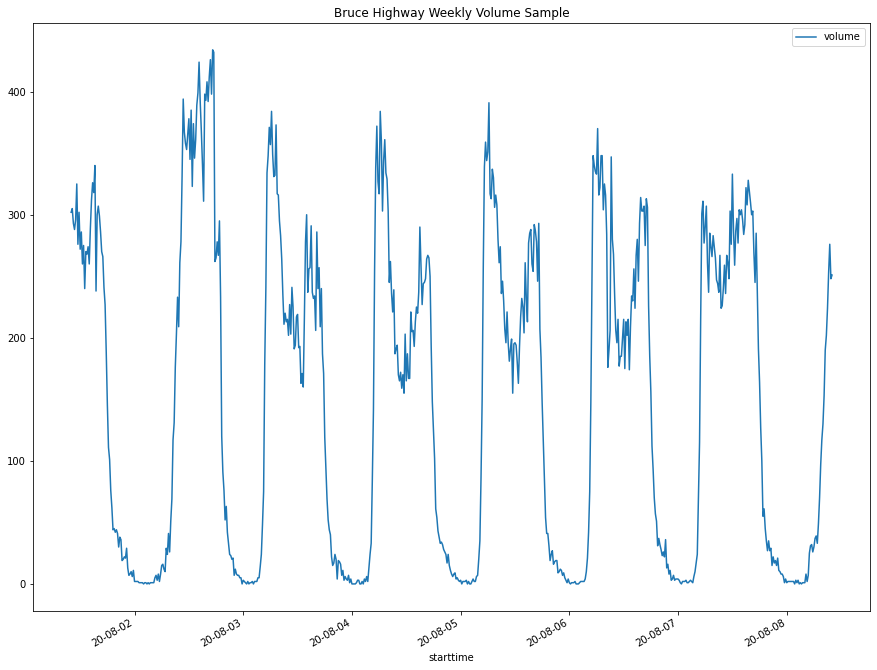

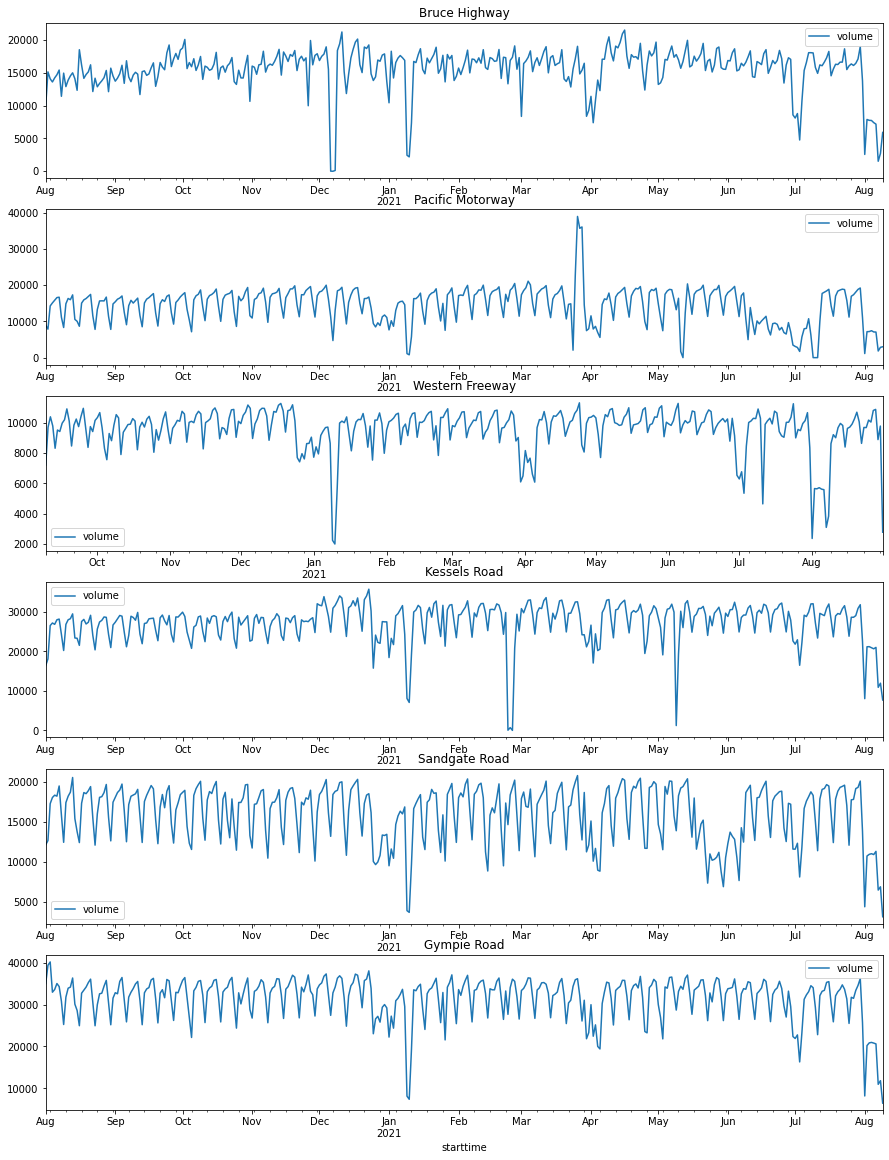

In [8]:
#Data visualisation
import matplotlib.dates as mdates
def load_dataset(path):
    df = pd.read_csv(path,usecols=['starttime','volume'])
    df = df.sort_values(by=['starttime'])
    #convert starttime to UTC+10
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['starttime'] = df['starttime'] + pd.Timedelta(hours=10)
    df.set_index('starttime',inplace=True)
    return df
    
Bruce = load_dataset('../Data/Bruce.csv')
Pacific = load_dataset('../Data/Pacific.csv')
Western = load_dataset('../Data/Western.csv')
Kessels = load_dataset('../Data/Kessels.csv')
Sandgate = load_dataset('../Data/Sandgate.csv')
Gympie = load_dataset('../Data/Gympie.csv')

#create another plot of Bruce with only first 150 rows  
Bruce_week = Bruce.iloc[:672]
ax = Bruce_week.plot(y='volume',title='Bruce Highway Weekly Volume Sample',figsize=(15,12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m-%d"))
plt.show()

#resample to daily so it's easier to plot
Bruce = Bruce.resample('D').sum()
Pacific = Pacific.resample('D').sum()
Western = Western.resample('D').sum()
Kessels = Kessels.resample('D').sum()
Sandgate = Sandgate.resample('D').sum()
Gympie = Gympie.resample('D').sum()

#create a subplot for each location
fig, axs = plt.subplots(6,1,figsize=(15,20))
#plot each location
Bruce.plot(y='volume',ax=axs[0])
Pacific.plot(y='volume',ax=axs[1])
Western.plot(y='volume',ax=axs[2])
Kessels.plot(y='volume',ax=axs[3])
Sandgate.plot(y='volume',ax=axs[4])
Gympie.plot(y='volume',ax=axs[5])
#add labels
axs[0].set_title('Bruce Highway')
axs[1].set_title('Pacific Motorway')
axs[2].set_title('Western Freeway')
axs[3].set_title('Kessels Road')
axs[4].set_title('Sandgate Road')
axs[5].set_title('Gympie Road')
plt.show()

### LSTM

#### Univariate Vector Output

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

#create train test split and convert to np arrays
train,test = create_univariate_dataset("../Data/Western.csv")
train_arr = train['volume'].to_numpy().astype(int)

#reshape the data for scaler and normaise the data
train_arr = train_arr.reshape(-1,1)
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_arr)

#split sequence into then reshape into [samples,timesteps,features]
n_input_steps,n_output_steps,n_features = 36,12,1
X,y = split_sequence(train_scaled,n_input_steps,n_output_steps)
X = X.reshape((X.shape[0], X.shape[1], n_features))

#print x and y shapes
print("X shape: {}",X.shape)
print("y shape: {}",y.shape)

# define model
model = Sequential()
model.add(LSTM(80, activation='relu', return_sequences=True, input_shape=(n_input_steps, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(80, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(80, activation='relu'))
model.add(Dense(n_output_steps, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
# fit model
history = model.fit(X, y, epochs=50, verbose=1, validation_split=0.2, callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='../Models/wf_model_version??.h5', monitor='val_loss', save_best_only=True)])

Let's check validation and training losses

dict_keys(['loss', 'mape', 'val_loss', 'val_mape'])


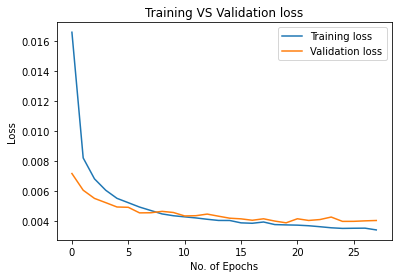

In [96]:
print(history.history.keys())
#check for overfitting using loss plots
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training vs Validation loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#for testing purposes load the model from file incase it isn't in memory
from keras.models import load_model
model2 = load_model('../Models/problem_model_14_3.h5')

Based off the validation losses it should perform pretty well on unseen data, let's see using a single sample of the test set

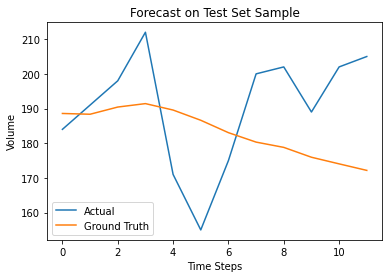

MSE: 406.092


In [93]:

test_sample = test.iloc[0:36]
test_sample = test_sample['volume'].to_numpy().astype(int)
test_actual = test.iloc[36:48]
test_actual = test_actual['volume'].to_numpy().astype(int)
test_sample = test_sample.reshape(-1,1)
test_sample_scaled = scaler.transform(test_sample)
x_input_test = test_sample_scaled.reshape((1, 36, 1))
yhat_test = model.predict(x_input_test, verbose=0)
inverse_yhat_test = scaler.inverse_transform(yhat_test)

#plot actual vs inverse_yhat
plt.plot(test_actual, label='Actual')
plt.plot(inverse_yhat_test.flatten(), label='Ground Truth')
plt.title("Forecast on Test Set Sample")
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()

#print mse
mse = mean_squared_error(test_actual, inverse_yhat_test.flatten())
print('MSE: %.3f' % mse)

Okay, that's pretty shit. Theoretically it should be good on data it's seen before right?

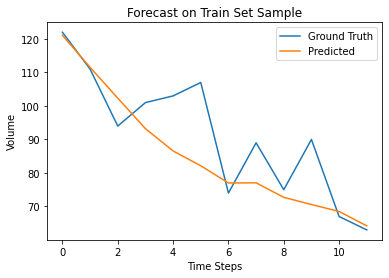

MSE: 129.678


In [95]:
#how is it on the train set? it should be good right?
train_sample = train.iloc[0:36]
t_sample = train_sample['volume'].to_numpy().astype(int)
actual = train.iloc[36:48]
actual = actual['volume'].to_numpy().astype(int)
t_sample = t_sample.reshape(-1,1)
t_sample_scaled = scaler.transform(t_sample)
x_input = t_sample_scaled.reshape((1, 36, 1))
yhat = model.predict(x_input, verbose=0)
inverse_yhat = scaler.inverse_transform(yhat)

#plot actual vs inverse_yhat
plt.plot(actual, label='Ground Truth')
plt.plot(inverse_yhat.flatten(), label='Predicted')
plt.title("Forecast on Train Set Sample")
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()

mse = mean_squared_error(actual, inverse_yhat.flatten())
print('MSE: %.3f' % mse)

Hmmm....interesting